# Stacking Data Tables
<br>

[Data Tables](#Stack-and-View-Data-Tables)

[Corner Plots](#Corner-Plots)
<br><br>

Put all the .dat output files in one directory with this notebook and then run it. It will stack all the tables together and make corner plots. This also assumes that you have 'Table2_Zucker2021.dat' from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/QKYR3G

In [4]:
################################################
# 
# Imports
#
################################################

from skimage.morphology import flood    
import skimage.morphology as mo

from astropy.io import fits
from astropy.table import QTable
from astropy.io import ascii
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.table import Table, hstack
from astropy.table import vstack, Table

from fil_finder import FilFinderPPP

import math

import numpy as np

from scipy import interpolate
from scipy.interpolate import splprep, splev
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import PillowWriter
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolor
from matplotlib.colors import BoundaryNorm

import corner

import pyvista as pv

import glob

import seaborn

import pandas as pd

# Stack and View Data Tables

Run the next few cells to view the stacked data table 

In [5]:
# After moving all the .dat files from the skeleton runs, run the next three cells 

data_table = glob.glob('n*.dat')
print(data_table)

['nht_35_x1465y1390z1400_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1465y1400z1395_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1470y1400z1395_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1465y1405z1395_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1475y1390z1395_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1465y1400z1400_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1470y1400z1400_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1465y1405z1400_data_table_core_thresholded_Zucker2021.dat', 'nht_35_x1475y1390z1400_data_table_core_thresholded_Zucker2021.dat']


In [6]:
stacked_table = []

for n in range(len(data_table)):
    table_file_name = data_table[n] 
    t = Table.read(table_file_name, format='ascii')
    stacked_table = vstack([stacked_table, t])

stacked_table.write('stacked_table.dat',overwrite=True,format='ascii')

Load in the number of star-forming sinks per cloud file (see Star-Forming-Sinks-Tutorial)

In [7]:
sink_table = Table.read('Number_sinks_per_cloud', format = 'ascii')

In [8]:
sink_table.show_in_notebook()

idx,Designation,Skeleton Index,Number Sinks
0,x1465y1390z1400,0,77
1,x1465y1390z1400,1,0
2,x1465y1390z1400,2,0
3,x1465y1390z1400,3,9
4,x1465y1390z1400,4,15
5,x1465y1390z1400,5,0
6,x1465y1390z1400,6,0
7,x1465y1390z1400,7,0
8,x1465y1390z1400,8,0
9,x1465y1390z1400,9,0


Manually add the sink column to the stacked table

In [9]:
sink_column = []

for row in stacked_table:

    indices_in_stacked_table_designation = np.where(sink_table['Designation'] == row['Designation'])
    indices_in_stacked_table_skeleton_index = np.where(sink_table['Skeleton Index'] == row['Skeleton Index'])

    index = np.intersect1d(indices_in_stacked_table_designation,indices_in_stacked_table_skeleton_index)

    sink_column.append(sink_table[index]['Number Sinks'])


In [10]:
stacked_table = hstack([stacked_table, sink_column])
stacked_table.rename_column('col0_2', 'Number Sinks')

Show the stacked table in the notebook

In [11]:
stacked_table.show_in_notebook()

idx,col0_1,Designation,Thresholded By (cm^-3),Threshold Level (cm^-3),Skeleton Index,Length (pc),Mass (Solar),NHTOT a1,NHTOT sigma 1,NHTOT a2,NHTOT sigma 2,NHTOT a,NHTOT sigma,NCO a,NCO sigma,NH2 a,NH2 sigma,NH1 a,NH1 sigma,NHTOT Max (cm^-3),NHTOT Median (cm^-3),NHTOT Mean (cm^-3),NCO Max (cm^-3),NCO Median (cm^-3),NCO Mean (cm^-3),NH2 Max (cm^-3),NH2 Median (cm^-3),NH2 Mean (cm^-3),NH1 Max (cm^-3),NH1 Median (cm^-3),NH1 Mean (cm^-3),CO Dark?,Molecular?,Atomic?,Core Shifted?,Core Thresholded?,Thresholded Core (cm^-3),First 2 pc ignored?,Number Sinks
0,--,x1465y1390z1400,nht,35.0,0,545,322558,54.0,2.1,6.6,6.5,50.0,2.7,1.9e-06,0.99,21.0,2.4,10.0,0.99,11000.0,17.0,98.0,1.5,2.4e-09,0.0085,4300.0,5.6,38.0,2300.0,4.4,22.0,True,True,False,False,True,> 35,True,77
1,--,x1465y1390z1400,nht,35.0,1,34,3925,37.0,2.4,6.2,7.5,35.0,3.3,7.1e-09,1.2,1.6,2.2,33.0,1.2,110.0,25.0,35.0,1.2e-07,2.5e-10,1.2e-08,5.2,1.0,1.4,100.0,23.0,32.0,True,False,True,False,True,> 35,True,0
2,--,x1465y1390z1400,nht,35.0,2,20,2124,69.0,1.5,9.8,3.3,56.0,1.9,1.4e-08,0.82,1.9,1.6,52.0,0.82,330.0,27.0,73.0,1.4e-05,5.7e-10,1.1e-06,28.0,0.97,4.6,270.0,25.0,64.0,True,False,True,False,True,> 35,True,0
3,--,x1465y1390z1400,nht,35.0,3,87,18735,54.0,0.96,13.0,3.6,16.0,3.3,2.9e-09,1.7,4.6,3.2,7.2,1.7,67.0,11.0,17.0,4.5e-07,8.3e-10,2.6e-08,25.0,3.2,5.2,34.0,4.7,6.2,True,True,False,False,True,> 35,True,9
4,--,x1465y1390z1400,nht,35.0,4,225,37483,69.0,1.1,18.0,3.9,27.0,3.2,1.3e-07,1.5,12.0,3.0,2.4,1.5,1100.0,9.3,32.0,0.11,1.1e-09,0.00088,540.0,3.5,14.0,37.0,1.5,3.2,True,True,False,False,True,> 35,True,15
5,--,x1465y1390z1400,nht,35.0,6,22,880,42.0,1.9,2.3,100.0,38.0,2.3,5.7e-09,1.5,9.8,1.9,5.4,1.5,100.0,6.1,18.0,3.8e-07,4.9e-12,2e-08,30.0,1.2,3.6,50.0,4.6,11.0,True,True,False,False,True,> 35,True,0
6,--,x1465y1390z1400,nht,35.0,7,137,11312,23.0,1.5,5.3,4.7,15.0,2.9,1.5e-08,0.89,3.7,2.7,9.3,0.89,68.0,4.1,9.1,6.6e-08,4.4e-12,2e-09,20.0,0.84,2.3,28.0,2.5,4.4,True,True,False,False,True,> 35,True,0
7,--,x1465y1390z1400,nht,35.0,9,22,967,94.0,0.77,31.0,3.1,37.0,2.8,2.8e-09,2.3,14.0,2.7,7.5,2.3,91.0,9.1,17.0,4.4e-07,6.3e-10,2.3e-08,40.0,3.1,6.2,13.0,4.0,4.9,True,True,False,False,True,> 35,True,0
8,--,x1465y1390z1400,nht,35.0,10,21,1196,33.0,2.8,2.2,13.0,33.0,3.2,5.6e-10,0.74,0.36,0.94,33.0,0.74,46.0,27.0,28.0,7.8e-11,4.5e-12,2.3e-11,0.094,0.02,0.033,46.0,27.0,28.0,True,False,True,False,True,> 35,True,0
9,--,x1465y1390z1400,nht,35.0,11,27,1044,14.0,1.7,14.0,3.7,22.0,3.2,3.3e-09,1.5,4.8,2.9,13.0,1.5,72.0,15.0,19.0,6.1e-08,1.6e-10,3.4e-09,16.0,2.9,3.8,41.0,9.1,11.0,True,False,True,False,True,> 35,True,0


Load in the observational data from Zucker 2021

In [13]:
# This is used to pull up the observation data, which is under 'Table2_Zucker2021.dat'

observation_data_table = glob.glob('T*.dat')
observation_stacked_table = t = Table.read(observation_data_table[0], format='ascii')

observation_stacked_table.write('observation_stacked_table.dat',overwrite=True,format='ascii')

In [15]:
observation_stacked_table.show_in_notebook()

idx,cloud,sigma1,sigma1_lower_err,sigma1_upper_err,a1,a1_lower_err,a1_upper_err,sigma2,sigma2_lower_err,sigma2_upper_err,a2,a2_lower_err,a2_upper_err,sigma_n_sq_g2,sigma_n_sq_g2_lower_err,sigma_n_sq_g2_upper_err,sigma2_over_sigma1,evidence_g2,n0,n0_lower_err,n0_upper_err,rflat,rflat_lower_err,rflat_upper_err,p,p_lower_err,p_upper_err,sigma_n_sq_plummer,sigma_n_sq_plummer_lower_err,sigma_n_sq_plummer_upper_err,evidence_plummer,sigma,sigma_lower_err,sigma_upper_err,a,a_lower_err,a_upper_err,sigma_n_sq_g1,sigma_n_sq_g1_lower_err,sigma_n_sq_g1_upper_err,evidence_g1
0,Chamaeleon,2.9,0.1,0.1,31.3,0.6,0.5,10.2,0.3,0.4,8.7,0.5,0.5,0.2,0.0,0.0,3.5,-2.9,47.8,1.2,1.5,3.1,0.2,0.1,1.8,0.1,0.1,0.1,0.0,0.0,-1.5,4.8,0.3,0.3,30.8,2.0,2.1,6.1,1.3,1.9,-58.0
1,Ophiuchus,2.7,0.2,0.2,31.1,1.5,1.6,10.1,0.5,0.6,12.6,1.1,1.1,0.8,0.2,0.2,3.8,-27.2,56.0,2.9,3.5,2.3,0.2,0.2,1.4,0.0,0.0,0.3,0.1,0.1,-11.9,5.8,0.4,0.5,29.1,2.0,2.0,9.5,2.0,2.6,-64.7
2,Lupus,2.6,0.2,0.3,30.6,1.8,1.8,8.1,0.5,0.6,15.5,2.0,1.9,0.9,0.2,0.3,3.1,-29.2,48.6,1.9,2.3,3.6,0.3,0.3,1.9,0.1,0.1,0.5,0.1,0.1,-19.3,5.2,0.3,0.3,32.7,1.7,1.8,6.2,1.3,1.7,-58.1
3,Taurus,2.6,0.1,0.1,30.9,1.1,1.2,11.9,0.5,0.6,9.2,0.5,0.5,0.4,0.1,0.1,4.6,-17.4,72.8,11.1,22.7,1.2,0.3,0.3,1.2,0.0,0.0,0.4,0.1,0.1,-17.3,5.8,0.6,0.6,24.3,2.2,2.4,10.3,2.3,3.3,-65.7
4,Perseus,4.1,0.1,0.1,34.3,0.9,0.9,11.9,0.6,0.8,10.9,1.0,1.0,0.3,0.1,0.1,2.9,-15.0,47.8,0.9,0.9,6.1,0.3,0.3,2.4,0.1,0.1,0.5,0.1,0.1,-20.7,6.0,0.2,0.2,39.0,1.5,1.6,6.9,1.4,2.1,-60.4
5,Musca,3.1,0.1,0.1,31.8,1.5,1.5,17.9,3.0,4.1,4.9,0.6,0.7,1.3,0.3,0.4,5.8,-34.4,48.3,5.5,8.4,2.5,0.5,0.6,1.6,0.2,0.2,2.4,0.5,0.7,-44.5,4.4,0.4,0.4,29.8,2.9,3.0,8.9,2.0,2.7,-63.8
6,Pipe,4.1,0.4,0.4,25.5,2.8,2.7,9.7,1.2,2.5,9.0,3.4,3.3,1.5,0.3,0.5,2.4,-36.7,35.5,1.4,1.5,7.7,1.0,1.2,3.4,0.5,0.6,1.4,0.3,0.4,-35.5,5.7,0.2,0.2,30.6,1.1,1.2,3.5,0.7,1.1,-49.3
7,Cepheus,2.5,0.1,0.1,46.6,1.6,1.7,10.9,0.6,0.7,10.1,0.7,0.7,0.7,0.2,0.2,4.4,-26.4,116.9,17.5,23.7,1.3,0.2,0.2,1.4,0.0,0.0,0.5,0.1,0.2,-21.6,4.3,0.4,0.4,39.1,3.7,3.9,14.3,3.0,4.2,-71.4
8,Oriona,2.9,0.1,0.1,52.4,1.8,1.8,8.4,0.8,1.0,8.8,1.7,1.9,1.3,0.3,0.4,2.9,-35.0,68.3,3.0,3.4,4.4,0.4,0.5,3.1,0.3,0.3,1.5,0.3,0.5,-37.2,3.7,0.1,0.1,53.1,2.4,2.5,5.8,1.3,1.8,-57.5
9,Orionb,4.9,0.1,0.1,39.2,1.1,1.1,14.6,1.3,1.9,9.0,1.2,1.3,0.3,0.1,0.1,3.0,-13.6,50.3,0.8,0.8,8.1,0.4,0.5,3.0,0.2,0.2,0.6,0.1,0.2,-23.6,6.5,0.2,0.2,43.8,1.3,1.4,5.9,1.2,1.8,-58.0


# Corner Plots

### 2-comp NHTOT Gaussian Variables Compared - Simulated Star Forming vs Observations

In [22]:
# Combining the Two Data Tables

# Sims 
designation = np.array(stacked_table['Designation'])
skeleton_index = np.array(stacked_table['Skeleton Index'])

nhtot_a1 = np.array(stacked_table['NHTOT a1'])
nhtot_a2 = np.array(stacked_table['NHTOT a2'])
nhtot_s1 = np.array(stacked_table['NHTOT sigma 1'])
nhtot_s2 = np.array(stacked_table['NHTOT sigma 2'])
star_forming_or_not = np.array(stacked_table['Number Sinks']).flatten()

# We need to only get the star-forming ones before we add the observations
nhtot_a1 = nhtot_a1[star_forming_or_not > 0]
nhtot_a2 = nhtot_a2[star_forming_or_not > 0]
nhtot_s1 = nhtot_s1[star_forming_or_not > 0]
nhtot_s2 = nhtot_s2[star_forming_or_not > 0]

# Created so that seaborn can distinguish between sims and observations 
sim_column = np.full_like(nhtot_a1, 'Simulation', dtype=object)

star_forming_or_not = star_forming_or_not[star_forming_or_not > 0]
star_forming_or_not_new = []

for n in range(len(star_forming_or_not)):
    
    if star_forming_or_not[n] > 0:
        star_forming_or_not_new.append('Simulated Star-Forming')
    else:
        star_forming_or_not_new.append('Simulted Non-Star-Forming')
        
star_forming_or_not_new = np.array(star_forming_or_not_new)
star_forming_or_not = star_forming_or_not_new

# Obs 
nhtot_a1_obs = np.array(observation_stacked_table['a1'])
nhtot_a2_obs = np.array(observation_stacked_table['a2'])
nhtot_s1_obs = np.array(observation_stacked_table['sigma1'])
nhtot_s2_obs = np.array(observation_stacked_table['sigma2'])
obs_column = np.full_like(nhtot_a1_obs, 'Observation', dtype=object)

# Combining 
nhtot_a1_combined = np.hstack((nhtot_a1,nhtot_a1_obs))
nhtot_s1_combined = np.hstack((nhtot_s1,nhtot_s1_obs))
nhtot_a2_combined = np.hstack((nhtot_a2,nhtot_a2_obs))
nhtot_s2_combined = np.hstack((nhtot_s2,nhtot_s2_obs))
nhtot_type_combined = np.hstack((star_forming_or_not,obs_column))

# Making data frames
dfa1 = pd.DataFrame(nhtot_a1_combined,columns = ['NHTOT A1 (cm^-3)'])
dfs1 = pd.DataFrame(nhtot_s1_combined,columns = ['NHTOT Sigma 1 (pc)'])
dfa2 = pd.DataFrame(nhtot_a2_combined, columns = ['NHTOT A2 (cm^-3)'])
dfs2 = pd.DataFrame(nhtot_s2_combined,columns = ['NHTOT Sigma 2 (pc)'])
df_type = pd.DataFrame(nhtot_type_combined, columns = ['Simulation or Observation'])
df_molecular = pd.DataFrame(star_forming_or_not, columns = ['Star Forming?'])

Text(0.5, 30.94444444444462, '$\\sigma_2$ ($pc$)')

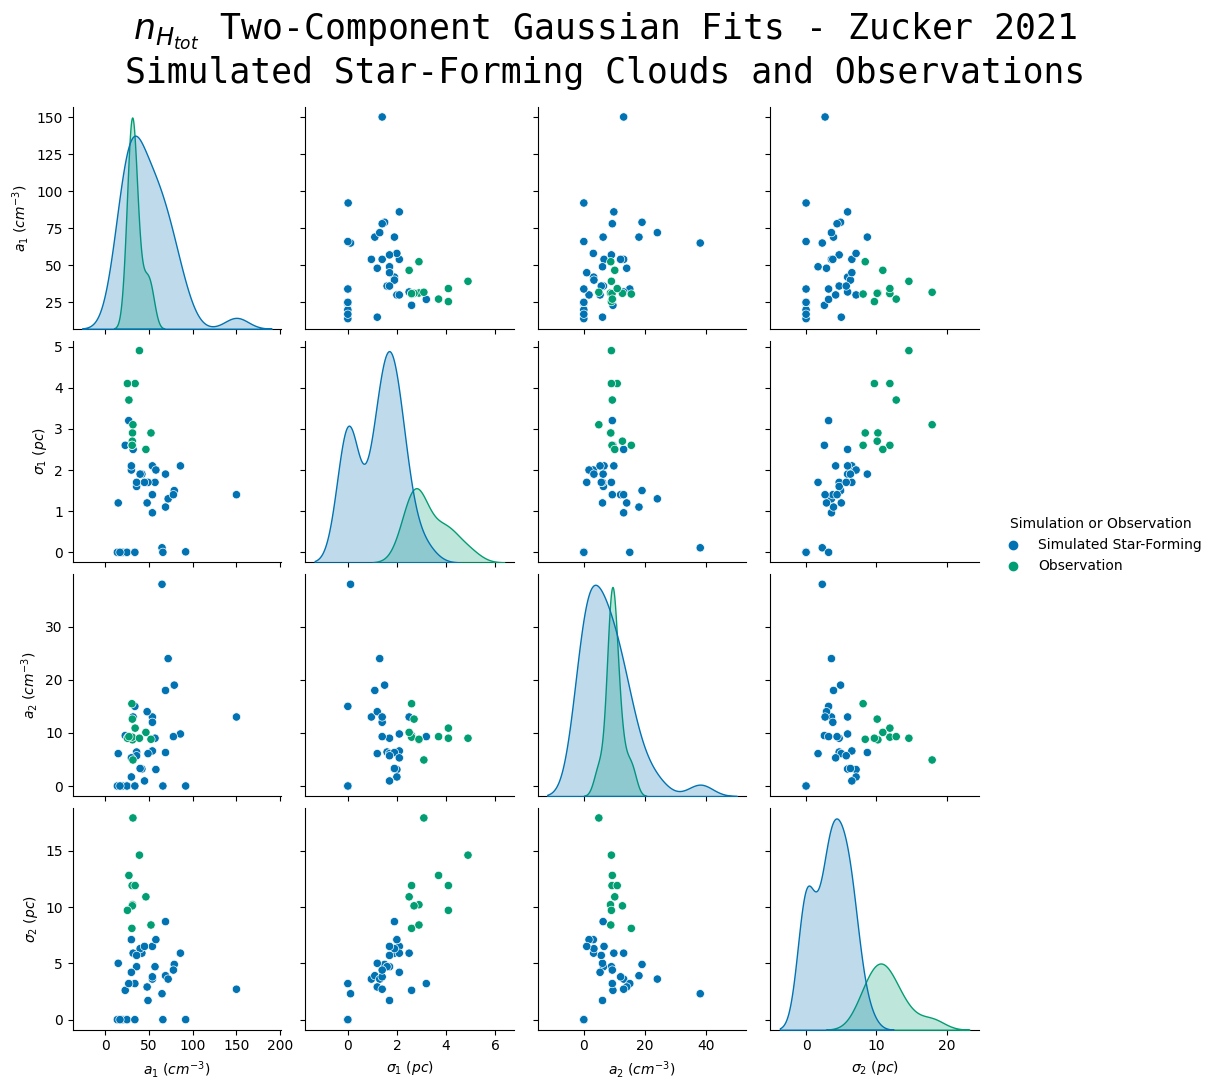

In [23]:
df = pd.concat([dfa1,dfs1,dfa2,dfs2,df_type],axis = 1)

colors = seaborn.color_palette("colorblind", 3)
palette ={"Simulated Star-Forming": colors[0], "Simulated Non-Star-Forming": colors[1], "Observation": colors[2]}

g = seaborn.pairplot(df,hue='Simulation or Observation', palette=palette)

g.fig.suptitle("$n_{H_{tot}}$ Two-Component Gaussian Fits - Zucker 2021\nSimulated Star-Forming Clouds and Observations", y=1.08,
              fontsize=25, family='monospace')

g.axes[0,0].yaxis.set_label_text('$a_1$ ($cm^{-3}$)')
g.axes[1,0].yaxis.set_label_text('$\sigma_1$ ($pc$)')
g.axes[2,0].yaxis.set_label_text('$a_2$ ($cm^{-3}$)')
g.axes[3,0].yaxis.set_label_text('$\sigma_2$ ($pc$)')

g.axes[3,0].xaxis.set_label_text('$a_1$ ($cm^{-3}$)')
g.axes[3,1].xaxis.set_label_text('$\sigma_1$ ($pc$)')
g.axes[3,2].xaxis.set_label_text('$a_2$ ($cm^{-3}$)')
g.axes[3,3].xaxis.set_label_text('$\sigma_2$ ($pc$)')

# Star-Forming Sims vs Observations (Outliers Clipped)

In [43]:
# Combining the Two 

# Sims 
designation = np.array(stacked_table['Designation'])
skeleton_index = np.array(stacked_table['Skeleton Index'])

nhtot_a1 = np.array(stacked_table['NHTOT a1'])
nhtot_a2 = np.array(stacked_table['NHTOT a2'])
nhtot_s1 = np.array(stacked_table['NHTOT sigma 1'])
nhtot_s2 = np.array(stacked_table['NHTOT sigma 2'])
star_forming_or_not = np.array(stacked_table['Number Sinks']).flatten()

# We need to only get the molecular ones before we add the observations
nhtot_a1 = nhtot_a1[star_forming_or_not > 0]
nhtot_a2 = nhtot_a2[star_forming_or_not > 0]
nhtot_s1 = nhtot_s1[star_forming_or_not > 0]
nhtot_s2 = nhtot_s2[star_forming_or_not > 0]

# Created so that seaborn can distinguish between sims and observations 
sim_column = np.full_like(nhtot_a1, 'Simulation', dtype=object)

star_forming_or_not = star_forming_or_not[star_forming_or_not > 0]
star_forming_or_not_new = []

for n in range(len(star_forming_or_not)):
    
    if star_forming_or_not[n] > 0:
        star_forming_or_not_new.append('Simulated Star-Forming')
    else:
        star_forming_or_not_new.append('Simulted Non-Star-Forming')
        
star_forming_or_not_new = np.array(star_forming_or_not_new)
star_forming_or_not = star_forming_or_not_new

# Obs 
nhtot_a1_obs = np.array(observation_stacked_table['a1'])
nhtot_a2_obs = np.array(observation_stacked_table['a2'])
nhtot_s1_obs = np.array(observation_stacked_table['sigma1'])
nhtot_s2_obs = np.array(observation_stacked_table['sigma2'])
obs_column = np.full_like(nhtot_a1_obs, 'Observation', dtype=object)

# Quantile the simulations only 
print('Quantiles')
print('NHTOT A1 ', np.quantile(nhtot_a1,0.9545))
print('NHTOT A2 ', np.quantile(nhtot_a2,0.9545))
print('NHTOT S1 ', np.quantile(nhtot_s1,0.9545))
print('NHTOT S2 ', np.quantile(nhtot_s2,0.9545))

nhtot_a1_quantile = np.quantile(nhtot_a1,0.9545)
nhtot_a2_quantile = np.quantile(nhtot_a2,0.9545)
nhtot_s1_quantile = np.quantile(nhtot_s1,0.9545)
nhtot_s2_quantile = np.quantile(nhtot_s2,0.9545)

#### PREOCOMPUTE THESE AND SAVE THEM
star_forming_or_not = star_forming_or_not[nhtot_a1 <= nhtot_a1_quantile]
nhtot_a2 = nhtot_a2[nhtot_a1 <= nhtot_a1_quantile]
nhtot_s1 = nhtot_s1[nhtot_a1 <= nhtot_a1_quantile]
nhtot_s2 = nhtot_s2[nhtot_a1 <= nhtot_a1_quantile]
nhtot_a1 = nhtot_a1[nhtot_a1 <= nhtot_a1_quantile]

star_forming_or_not = star_forming_or_not[nhtot_a2 <= nhtot_a2_quantile]
nhtot_s1 = nhtot_s1[nhtot_a2 <= nhtot_a2_quantile]
nhtot_s2 = nhtot_s2[nhtot_a2 <= nhtot_a2_quantile]
nhtot_a1 = nhtot_a1[nhtot_a2 <= nhtot_a2_quantile]
nhtot_a2 = nhtot_a2[nhtot_a2 <= nhtot_a2_quantile]

star_forming_or_not = star_forming_or_not[nhtot_s1 <= nhtot_s1_quantile]
nhtot_s2 = nhtot_s2[nhtot_s1 <= nhtot_s1_quantile]
nhtot_a1 = nhtot_a1[nhtot_s1 <= nhtot_s1_quantile]
nhtot_a2 = nhtot_a2[nhtot_s1 <= nhtot_s1_quantile]
nhtot_s1 = nhtot_s1[nhtot_s1 <= nhtot_s1_quantile]

star_forming_or_not = star_forming_or_not[nhtot_s1 > 0]
nhtot_s2 = nhtot_s2[nhtot_s1 > 0]
nhtot_a1 = nhtot_a1[nhtot_s1 > 0]
nhtot_a2 = nhtot_a2[nhtot_s1 > 0]
nhtot_s1 = nhtot_s1[nhtot_s1 > 0]

star_forming_or_not = star_forming_or_not[nhtot_s2 <= nhtot_s2_quantile]
nhtot_a1 = nhtot_a1[nhtot_s2 <= nhtot_s2_quantile]
nhtot_a2 = nhtot_a2[nhtot_s2 <= nhtot_s2_quantile]
nhtot_s1 = nhtot_s1[nhtot_s2 <= nhtot_s2_quantile]
nhtot_s2 = nhtot_s2[nhtot_s2 <= nhtot_s2_quantile]

star_forming_or_not = star_forming_or_not[nhtot_s2 > 0]
nhtot_a1 = nhtot_a1[nhtot_s2 > 0]
nhtot_a2 = nhtot_a2[nhtot_s2 > 0]
nhtot_s1 = nhtot_s1[nhtot_s2 > 0]
nhtot_s2 = nhtot_s2[nhtot_s2 > 0]

# Combining 
nhtot_a1_combined = np.hstack((nhtot_a1,nhtot_a1_obs))
nhtot_s1_combined = np.hstack((nhtot_s1,nhtot_s1_obs))
nhtot_a2_combined = np.hstack((nhtot_a2,nhtot_a2_obs))
nhtot_s2_combined = np.hstack((nhtot_s2,nhtot_s2_obs))
nhtot_type_combined = np.hstack((star_forming_or_not,obs_column))

# Making data frames
dfa1 = pd.DataFrame(nhtot_a1_combined,columns = ['NHTOT A1 (cm^-3)'])
dfs1 = pd.DataFrame(nhtot_s1_combined,columns = ['NHTOT Sigma 1 (pc)'])
dfa2 = pd.DataFrame(nhtot_a2_combined, columns = ['NHTOT A2 (cm^-3)'])
dfs2 = pd.DataFrame(nhtot_s2_combined,columns = ['NHTOT Sigma 2 (pc)'])
df_type = pd.DataFrame(nhtot_type_combined, columns = ['Simulation or Observation'])
df_molecular = pd.DataFrame(star_forming_or_not, columns = ['Star-Forming?'])

Quantiles
NHTOT A1  88.445
NHTOT A2  21.037499999999994
NHTOT S1  2.54075
NHTOT S2  7.1


Text(0.5, 30.94444444444462, '$\\sigma_2$ ($pc$)')

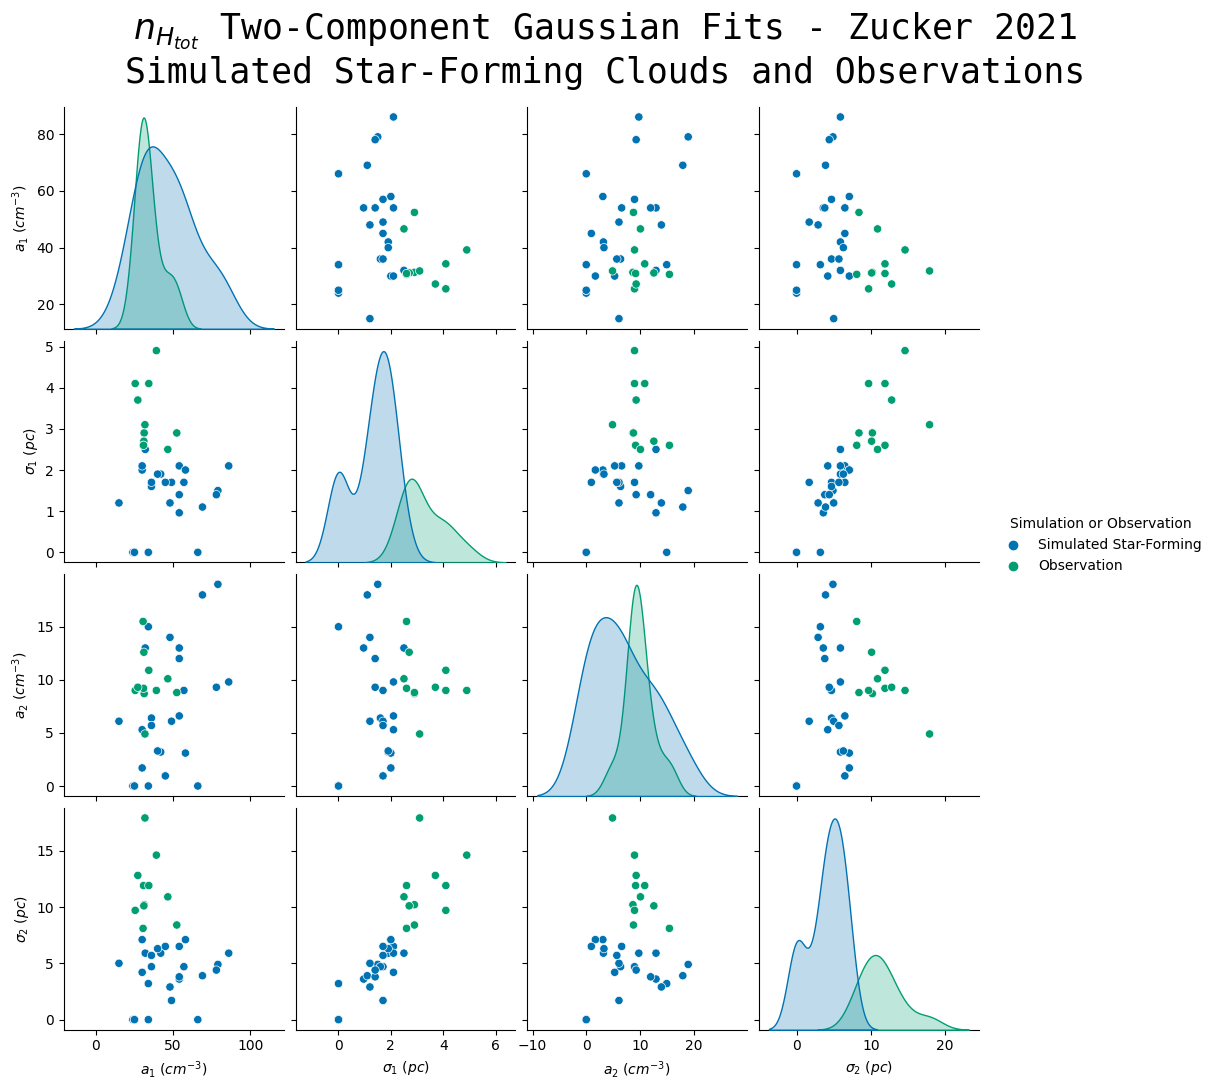

In [25]:
df = pd.concat([dfa1,dfs1,dfa2,dfs2,df_type],axis = 1)

colors = seaborn.color_palette("colorblind", 3)
palette ={"Simulated Star-Forming": colors[0], "Simulated Non-Star-Forming": colors[1], "Observation": colors[2]}

g = seaborn.pairplot(df,hue='Simulation or Observation', palette=palette)

g.fig.suptitle("$n_{H_{tot}}$ Two-Component Gaussian Fits - Zucker 2021\nSimulated Star-Forming Clouds and Observations", y=1.08,
              fontsize=25, family='monospace')

g.axes[0,0].yaxis.set_label_text('$a_1$ ($cm^{-3}$)')
g.axes[1,0].yaxis.set_label_text('$\sigma_1$ ($pc$)')
g.axes[2,0].yaxis.set_label_text('$a_2$ ($cm^{-3}$)')
g.axes[3,0].yaxis.set_label_text('$\sigma_2$ ($pc$)')

g.axes[3,0].xaxis.set_label_text('$a_1$ ($cm^{-3}$)')
g.axes[3,1].xaxis.set_label_text('$\sigma_1$ ($pc$)')
g.axes[3,2].xaxis.set_label_text('$a_2$ ($cm^{-3}$)')
g.axes[3,3].xaxis.set_label_text('$\sigma_2$ ($pc$)')


# Simulated Star-Forming vs Observations - Filtering out failed fits 

In [54]:
# Combining the Two 

# Sims 
designation = np.array(stacked_table['Designation'])
skeleton_index = np.array(stacked_table['Skeleton Index'])

nhtot_a1 = np.array(stacked_table['NHTOT a1'])
nhtot_a2 = np.array(stacked_table['NHTOT a2'])
nhtot_s1 = np.array(stacked_table['NHTOT sigma 1'])
nhtot_s2 = np.array(stacked_table['NHTOT sigma 2'])
star_forming_or_not = np.array(stacked_table['Number Sinks']).flatten()

# We need to only get the molecular ones before we add the observations
nhtot_a1 = nhtot_a1[star_forming_or_not > 0]
nhtot_a2 = nhtot_a2[star_forming_or_not > 0]
nhtot_s1 = nhtot_s1[star_forming_or_not > 0]
nhtot_s2 = nhtot_s2[star_forming_or_not > 0]

# Created so that seaborn can distinguish between sims and observations 
sim_column = np.full_like(nhtot_a1, 'Simulation', dtype=object)

star_forming_or_not = star_forming_or_not[star_forming_or_not > 0]
star_forming_or_not_new = []

for n in range(len(star_forming_or_not)):
    
    if star_forming_or_not[n] > 0:
        star_forming_or_not_new.append('Simulated Star-Forming')
    else:
        star_forming_or_not_new.append('Simulted Non-Star-Forming')
        
star_forming_or_not_new = np.array(star_forming_or_not_new)
star_forming_or_not = star_forming_or_not_new

# Obs 
nhtot_a1_obs = np.array(observation_stacked_table['a1'])
nhtot_a2_obs = np.array(observation_stacked_table['a2'])
nhtot_s1_obs = np.array(observation_stacked_table['sigma1'])
nhtot_s2_obs = np.array(observation_stacked_table['sigma2'])
obs_column = np.full_like(nhtot_a1_obs, 'Observation', dtype=object)

# Filter failted fits 

minimum = 0.5

star_forming_or_not = star_forming_or_not[nhtot_s2 > minimum]
nhtot_a1 = nhtot_a1[nhtot_s2 > minimum]
nhtot_a2 = nhtot_a2[nhtot_s2 > minimum]
nhtot_s1 = nhtot_s1[nhtot_s2 > minimum]
nhtot_s2 = nhtot_s2[nhtot_s2 > minimum]

star_forming_or_not = star_forming_or_not[nhtot_s1 > minimum]
nhtot_s2 = nhtot_s2[nhtot_s1 > minimum]
nhtot_a1 = nhtot_a1[nhtot_s1 > minimum]
nhtot_a2 = nhtot_a2[nhtot_s1 > minimum]
nhtot_s1 = nhtot_s1[nhtot_s1 > minimum]

max = 100

star_forming_or_not = star_forming_or_not[nhtot_a1 < max]
nhtot_a2 = nhtot_a2[nhtot_a1 < max]
nhtot_s1 = nhtot_s1[nhtot_a1 < max]
nhtot_s2 = nhtot_s2[nhtot_a1 < max]
nhtot_a1 = nhtot_a1[nhtot_a1 < max]

# Combining 
nhtot_a1_combined = np.hstack((nhtot_a1,nhtot_a1_obs))
nhtot_s1_combined = np.hstack((nhtot_s1,nhtot_s1_obs))
nhtot_a2_combined = np.hstack((nhtot_a2,nhtot_a2_obs))
nhtot_s2_combined = np.hstack((nhtot_s2,nhtot_s2_obs))
nhtot_type_combined = np.hstack((star_forming_or_not,obs_column))

# Making data frames
dfa1 = pd.DataFrame(nhtot_a1_combined,columns = ['NHTOT A1 (cm^-3)'])
dfs1 = pd.DataFrame(nhtot_s1_combined,columns = ['NHTOT Sigma 1 (pc)'])
dfa2 = pd.DataFrame(nhtot_a2_combined, columns = ['NHTOT A2 (cm^-3)'])
dfs2 = pd.DataFrame(nhtot_s2_combined,columns = ['NHTOT Sigma 2 (pc)'])
df_type = pd.DataFrame(nhtot_type_combined, columns = ['Simulation or Observation'])
df_molecular = pd.DataFrame(star_forming_or_not, columns = ['Star-Forming?'])

/var/folders/53/46t_qb2x7d92kd89wgxr9r880000gn/T/ipykernel_2331/417903062.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[3,1].set_xticklabels(x_ticks)
/var/folders/53/46t_qb2x7d92kd89wgxr9r880000gn/T/ipykernel_2331/417903062.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[3,2].set_xticklabels(x_ticks)
/var/folders/53/46t_qb2x7d92kd89wgxr9r880000gn/T/ipykernel_2331/417903062.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[3,3].set_xticklabels(x_ticks)
/var/folders/53/46t_qb2x7d92kd89wgxr9r880000gn/T/ipykernel_2331/417903062.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,0].set_yticklabels(y_ticks)
/var/folders/53/46t_qb2x7d92kd89wgxr9r880000gn/T/ipykernel_2331/417903062.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[1,0].set_yticklabels(y_ticks)
/var/folders/53/46t_qb2x7

Text(0.5, 30.94444444444462, '$\\sigma_2$ (pc)')

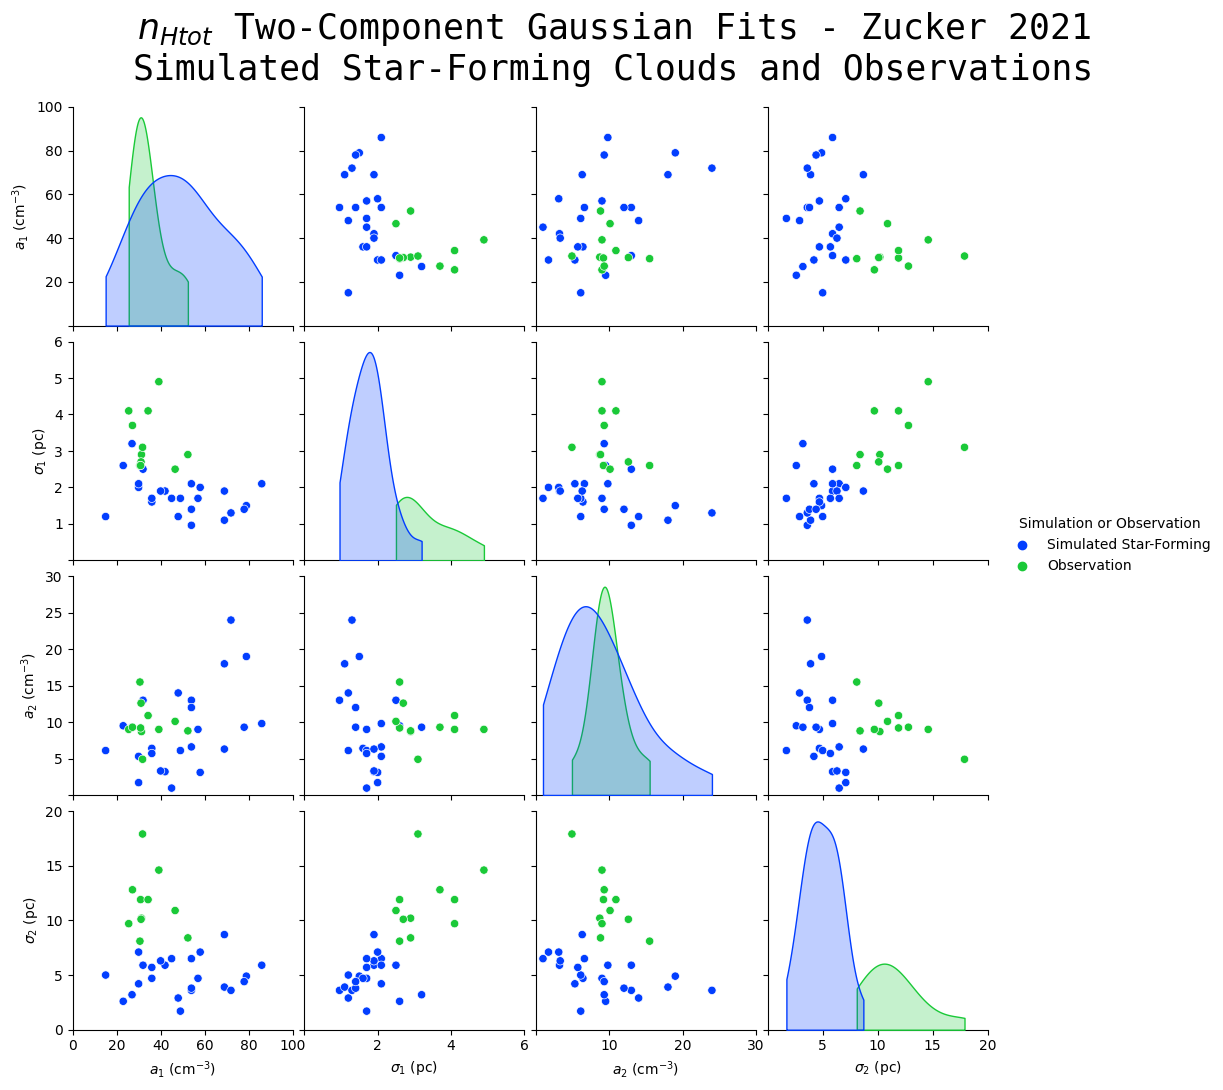

In [47]:
df = pd.concat([dfa1,dfs1,dfa2,dfs2,df_type],axis = 1)


colors = seaborn.color_palette("colorblind", 3)
colors = seaborn.color_palette("bright", 3)
palette ={"Simulated Star-Forming": colors[0], "Simulated Non-Star-Forming": colors[1], "Observation": colors[2]}

diag_kws = {'cut' : 0}
g = seaborn.pairplot(df,hue='Simulation or Observation', palette=palette, 
                     diag_kind = 'kde',diag_kws = diag_kws)


g.fig.suptitle("$n_{Htot}$ Two-Component Gaussian Fits - Zucker 2021\nSimulated Star-Forming Clouds and Observations", y=1.08,
              fontsize=25, family='monospace')

g.axes[3,0].set_xlim((0,100))
g.axes[3,1].set_xlim((0,6))
g.axes[3,2].set_xlim((0,30))
g.axes[3,3].set_xlim((0,20))

g.axes[0,0].set_ylim((0,100))
g.axes[1,0].set_ylim((0,6))
g.axes[2,0].set_ylim((0,30))
g.axes[3,0].set_ylim((0,20))

x_ticks = g.axes[3,1].get_xticklabels()
x_ticks[0] = ""
g.axes[3,1].set_xticklabels(x_ticks)
x_ticks = g.axes[3,2].get_xticklabels()
x_ticks[0] = ""
g.axes[3,2].set_xticklabels(x_ticks)
x_ticks = g.axes[3,3].get_xticklabels()
x_ticks[0] = ""
g.axes[3,3].set_xticklabels(x_ticks)

y_ticks = g.axes[0,0].get_yticklabels()
y_ticks[0] = ""
g.axes[0,0].set_yticklabels(y_ticks)
y_ticks = g.axes[1,0].get_yticklabels()
y_ticks[0] = ""
g.axes[1,0].set_yticklabels(y_ticks)
y_ticks = g.axes[2,0].get_yticklabels()
y_ticks[0] = ""
g.axes[2,0].set_yticklabels(y_ticks)

g.axes[0,0].set_yticklabels(g.axes[0,0].get_yticklabels())
g.axes[1,0].set_yticklabels(g.axes[1,0].get_yticklabels())
g.axes[2,0].set_yticklabels(g.axes[2,0].get_yticklabels())
g.axes[3,0].set_yticklabels(g.axes[3,0].get_yticklabels())

g.axes[0,0].yaxis.set_label_text('$a_1$ (cm$^{-3}$)')
g.axes[1,0].yaxis.set_label_text('$\sigma_1$ (pc)')
g.axes[2,0].yaxis.set_label_text('$a_2$ (cm$^{-3}$)')
g.axes[3,0].yaxis.set_label_text('$\sigma_2$ (pc)')

g.axes[3,0].xaxis.set_label_text('$a_1$ (cm$^{-3}$)')
g.axes[3,1].xaxis.set_label_text('$\sigma_1$ (pc)')
g.axes[3,2].xaxis.set_label_text('$a_2$ (cm$^{-3}$)')
g.axes[3,3].xaxis.set_label_text('$\sigma_2$ (pc)')


In [48]:
display(df)

,NHTOT A1 (cm^-3),NHTOT Sigma 1 (pc),NHTOT A2 (cm^-3),NHTOT Sigma 2 (pc),Simulation or Observation
0,54.0,2.10,6.60,6.5,Simulated Star-Forming
1,54.0,0.96,13.00,3.6,Simulated Star-Forming
2,69.0,1.10,18.00,3.9,Simulated Star-Forming
3,42.0,1.90,3.20,5.9,Simulated Star-Forming
4,23.0,2.60,9.50,2.6,Simulated Star-Forming
5,58.0,2.00,3.10,7.1,Simulated Star-Forming
6,72.0,1.30,24.00,3.6,Simulated Star-Forming
7,79.0,1.50,19.00,4.9,Simulated Star-Forming
8,32.0,2.50,13.00,5.9,Simulated Star-Forming
9,30.0,2.00,1.70,7.1,Simulated Star-Forming


# Simulated Star-Forming vs Non-Star-Forming vs Observations (Outliers Clipped)

In [40]:
# Combining the Two 

# Sims 
nhtot_a1 = np.array(stacked_table['NHTOT a1'])
nhtot_a2 = np.array(stacked_table['NHTOT a2'])
nhtot_s1 = np.array(stacked_table['NHTOT sigma 1'])
nhtot_s2 = np.array(stacked_table['NHTOT sigma 2'])
star_forming_or_not_op = np.array(stacked_table['Number Sinks']).flatten()

star_forming_or_not = []
count = 0

for n in range(len(star_forming_or_not_op)):
    
    if star_forming_or_not_op[n] > 0:
        star_forming_or_not.append('Simulated Star-Forming')
    else:
        star_forming_or_not.append('Simulated Non-Star-Forming')
        count += 1
        
print(count)
star_forming_or_not = np.array(star_forming_or_not)


# Quantile the simulations only 
print('Quantiles')
print('NHTOT A1 ', np.quantile(nhtot_a1,0.9545))
print('NHTOT A2 ', np.quantile(nhtot_a2,0.9545))
print('NHTOT S1 ', np.quantile(nhtot_s1,0.9545))
print('NHTOT S2 ', np.quantile(nhtot_s2,0.9545))

nhtot_a1_quantile = np.quantile(nhtot_a1,0.9545)
nhtot_a2_quantile = np.quantile(nhtot_a2,0.9545)
nhtot_s1_quantile = np.quantile(nhtot_s1,0.9545)
nhtot_s2_quantile = np.quantile(nhtot_s2,0.9545)

#### PREOCOMPUTE THESE AND SAVE THEM
star_forming_or_not = star_forming_or_not[nhtot_a1 <= nhtot_a1_quantile]
nhtot_a2 = nhtot_a2[nhtot_a1 <= nhtot_a1_quantile]
nhtot_s1 = nhtot_s1[nhtot_a1 <= nhtot_a1_quantile]
nhtot_s2 = nhtot_s2[nhtot_a1 <= nhtot_a1_quantile]
nhtot_a1 = nhtot_a1[nhtot_a1 <= nhtot_a1_quantile]

star_forming_or_not = star_forming_or_not[nhtot_a2 <= nhtot_a2_quantile]
nhtot_s1 = nhtot_s1[nhtot_a2 <= nhtot_a2_quantile]
nhtot_s2 = nhtot_s2[nhtot_a2 <= nhtot_a2_quantile]
nhtot_a1 = nhtot_a1[nhtot_a2 <= nhtot_a2_quantile]
nhtot_a2 = nhtot_a2[nhtot_a2 <= nhtot_a2_quantile]

star_forming_or_not = star_forming_or_not[nhtot_s1 <= nhtot_s1_quantile]
nhtot_s2 = nhtot_s2[nhtot_s1 <= nhtot_s1_quantile]
nhtot_a1 = nhtot_a1[nhtot_s1 <= nhtot_s1_quantile]
nhtot_a2 = nhtot_a2[nhtot_s1 <= nhtot_s1_quantile]
nhtot_s1 = nhtot_s1[nhtot_s1 <= nhtot_s1_quantile]

star_forming_or_not = star_forming_or_not[nhtot_s1 > 0]
nhtot_s2 = nhtot_s2[nhtot_s1 > 0]
nhtot_a1 = nhtot_a1[nhtot_s1 > 0]
nhtot_a2 = nhtot_a2[nhtot_s1 > 0]
nhtot_s1 = nhtot_s1[nhtot_s1 > 0]

star_forming_or_not = star_forming_or_not[nhtot_s2 <= nhtot_s2_quantile]
nhtot_a1 = nhtot_a1[nhtot_s2 <= nhtot_s2_quantile]
nhtot_a2 = nhtot_a2[nhtot_s2 <= nhtot_s2_quantile]
nhtot_s1 = nhtot_s1[nhtot_s2 <= nhtot_s2_quantile]
nhtot_s2 = nhtot_s2[nhtot_s2 <= nhtot_s2_quantile]

star_forming_or_not = star_forming_or_not[nhtot_s2 > 0]
nhtot_a1 = nhtot_a1[nhtot_s2 > 0]
nhtot_a2 = nhtot_a2[nhtot_s2 > 0]
nhtot_s1 = nhtot_s1[nhtot_s2 > 0]
nhtot_s2 = nhtot_s2[nhtot_s2 > 0]

# Created so that seaborn can distinguish between sims and observations 
sim_column = np.full_like(nhtot_a1, 'Simulation', dtype=object)

# Obs 
nhtot_a1_obs = np.array(observation_stacked_table['a1'])
nhtot_a2_obs = np.array(observation_stacked_table['a2'])
nhtot_s1_obs = np.array(observation_stacked_table['sigma1'])
nhtot_s2_obs = np.array(observation_stacked_table['sigma2'])
obs_column = np.full_like(nhtot_a1_obs, 'Observation', dtype=object)

# Combining 
nhtot_a1_combined = np.hstack((nhtot_a1,nhtot_a1_obs))
nhtot_s1_combined = np.hstack((nhtot_s1,nhtot_s1_obs))
nhtot_a2_combined = np.hstack((nhtot_a2,nhtot_a2_obs))
nhtot_s2_combined = np.hstack((nhtot_s2,nhtot_s2_obs))
nhtot_type_combined = np.hstack((star_forming_or_not,obs_column))

# Making data frames
dfa1 = pd.DataFrame(nhtot_a1_combined,columns = ['NHTOT A1 (cm^-3)'])
dfs1 = pd.DataFrame(nhtot_s1_combined,columns = ['NHTOT Sigma 1 (pc)'])
dfa2 = pd.DataFrame(nhtot_a2_combined, columns = ['NHTOT A2 (cm^-3)'])
dfs2 = pd.DataFrame(nhtot_s2_combined,columns = ['NHTOT Sigma 2 (pc)'])
df_type = pd.DataFrame(nhtot_type_combined, columns = ['Simulation or Observation'])

89
Quantiles
NHTOT A1  78.358
NHTOT A2  24.358000000000004
NHTOT S1  2.7358000000000007
NHTOT S2  11.716000000000008


Text(0.5, 30.94444444444462, '$\\sigma_2$ ($pc$)')

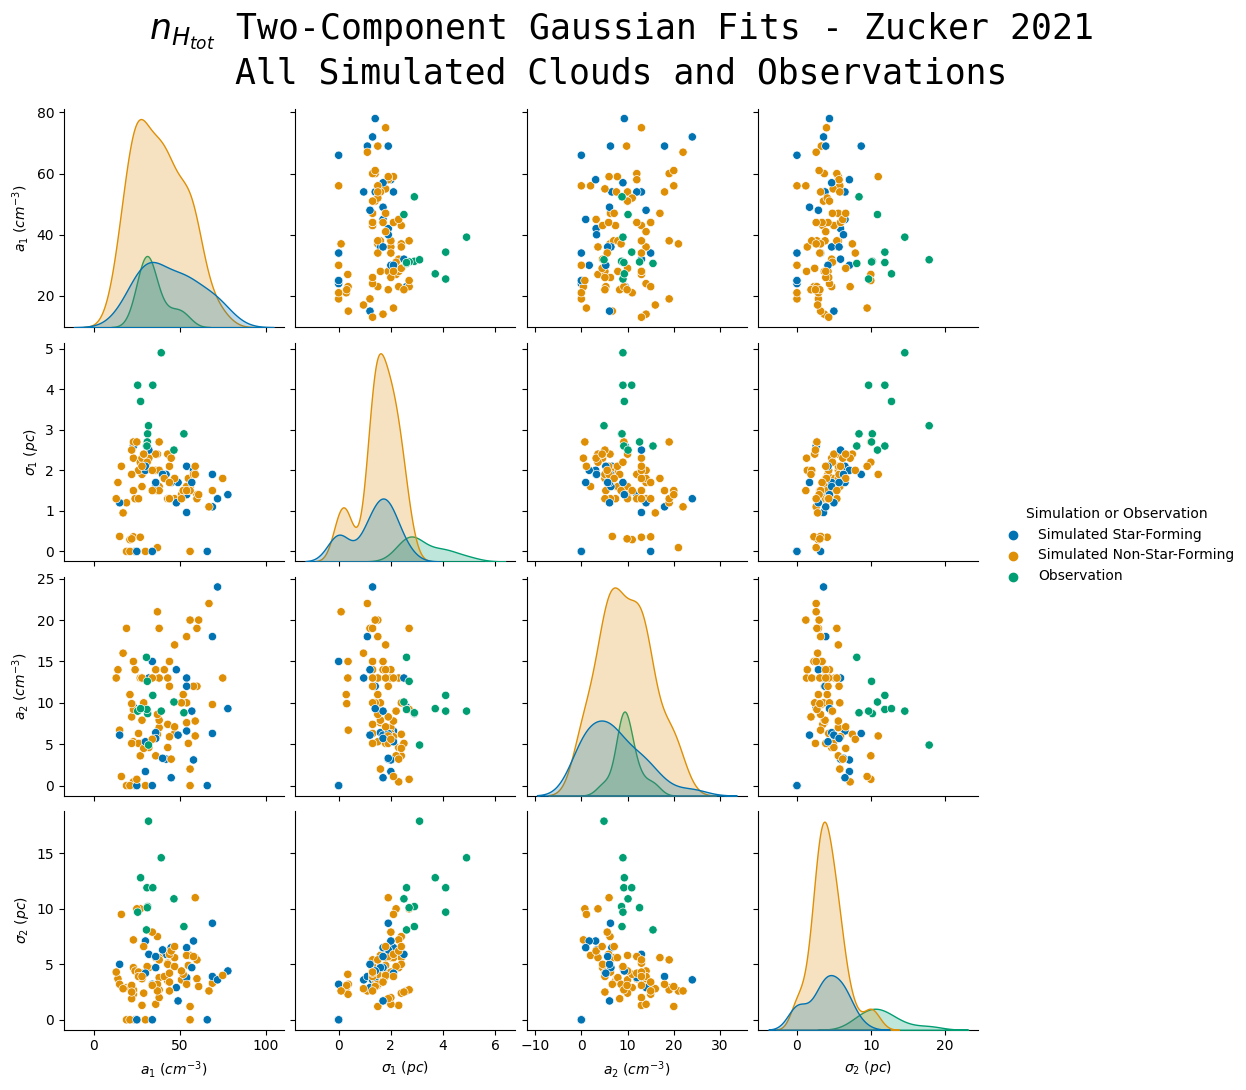

In [41]:
df = pd.concat([dfa1,dfs1,dfa2,dfs2,df_type,],axis = 1)

g = seaborn.pairplot(df,hue='Simulation or Observation',palette=palette)

g.fig.suptitle("$n_{H_{tot}}$ Two-Component Gaussian Fits - Zucker 2021\nAll Simulated Clouds and Observations", y=1.08,
              fontsize=25, family='monospace')

g.axes[0,0].yaxis.set_label_text('$a_1$ ($cm^{-3}$)')
g.axes[1,0].yaxis.set_label_text('$\sigma_1$ ($pc$)')
g.axes[2,0].yaxis.set_label_text('$a_2$ ($cm^{-3}$)')
g.axes[3,0].yaxis.set_label_text('$\sigma_2$ ($pc$)')

g.axes[3,0].xaxis.set_label_text('$a_1$ ($cm^{-3}$)')
g.axes[3,1].xaxis.set_label_text('$\sigma_1$ ($pc$)')
g.axes[3,2].xaxis.set_label_text('$a_2$ ($cm^{-3}$)')
g.axes[3,3].xaxis.set_label_text('$\sigma_2$ ($pc$)')


# Simulated Star-Forming vs Non-Star-Forming vs Observations - Filtering out bad fits

In [55]:
# Combining the Two 

# Sims 
nhtot_a1 = np.array(stacked_table['NHTOT a1'])
nhtot_a2 = np.array(stacked_table['NHTOT a2'])
nhtot_s1 = np.array(stacked_table['NHTOT sigma 1'])
nhtot_s2 = np.array(stacked_table['NHTOT sigma 2'])
star_forming_or_not_op = np.array(stacked_table['Number Sinks']).flatten()

star_forming_or_not = []
count = 0

for n in range(len(star_forming_or_not_op)):
    
    if star_forming_or_not_op[n] > 0:
        star_forming_or_not.append('Simulated Star-Forming')
    else:
        star_forming_or_not.append('Simulated Non-Star-Forming')
        count += 1
        
star_forming_or_not = np.array(star_forming_or_not)

minimum = 0.5

star_forming_or_not = star_forming_or_not[nhtot_s2 > minimum]
nhtot_a1 = nhtot_a1[nhtot_s2 > minimum]
nhtot_a2 = nhtot_a2[nhtot_s2 > minimum]
nhtot_s1 = nhtot_s1[nhtot_s2 > minimum]
nhtot_s2 = nhtot_s2[nhtot_s2 > minimum]

star_forming_or_not = star_forming_or_not[nhtot_s1 > minimum]
nhtot_s2 = nhtot_s2[nhtot_s1 > minimum]
nhtot_a1 = nhtot_a1[nhtot_s1 > minimum]
nhtot_a2 = nhtot_a2[nhtot_s1 > minimum]
nhtot_s1 = nhtot_s1[nhtot_s1 > minimum]

maximum = 100


star_forming_or_not = star_forming_or_not[nhtot_s2 < maximum]
nhtot_a1 = nhtot_a1[nhtot_s2 < maximum]
nhtot_a2 = nhtot_a2[nhtot_s2 < maximum]
nhtot_s1 = nhtot_s1[nhtot_s2 < maximum]
nhtot_s2 = nhtot_s2[nhtot_s2 < maximum]

star_forming_or_not = star_forming_or_not[nhtot_s1 < maximum]
nhtot_s2 = nhtot_s2[nhtot_s1 < maximum]
nhtot_a1 = nhtot_a1[nhtot_s1 < maximum]
nhtot_a2 = nhtot_a2[nhtot_s1 < maximum]
nhtot_s1 = nhtot_s1[nhtot_s1 < maximum]

max = 100

star_forming_or_not = star_forming_or_not[nhtot_a1 < max]
nhtot_a2 = nhtot_a2[nhtot_a1 < max]
nhtot_s1 = nhtot_s1[nhtot_a1 < max]
nhtot_s2 = nhtot_s2[nhtot_a1 < max]
nhtot_a1 = nhtot_a1[nhtot_a1 < max]

max = 30

star_forming_or_not = star_forming_or_not[nhtot_a2 < max]
nhtot_s1 = nhtot_s1[nhtot_a2 < max]
nhtot_s2 = nhtot_s2[nhtot_a2 < max]
nhtot_a1 = nhtot_a1[nhtot_a2 < max]
nhtot_a2 = nhtot_a2[nhtot_a2 < max]

# Created so that seaborn can distinguish between sims and observations 
sim_column = np.full_like(nhtot_a1, 'Simulation', dtype=object)

# Obs 
nhtot_a1_obs = np.array(observation_stacked_table['a1'])
nhtot_a2_obs = np.array(observation_stacked_table['a2'])
nhtot_s1_obs = np.array(observation_stacked_table['sigma1'])
nhtot_s2_obs = np.array(observation_stacked_table['sigma2'])
obs_column = np.full_like(nhtot_a1_obs, 'Observation', dtype=object)

# Combining 
nhtot_a1_combined = np.hstack((nhtot_a1,nhtot_a1_obs))
nhtot_s1_combined = np.hstack((nhtot_s1,nhtot_s1_obs))
nhtot_a2_combined = np.hstack((nhtot_a2,nhtot_a2_obs))
nhtot_s2_combined = np.hstack((nhtot_s2,nhtot_s2_obs))
nhtot_type_combined = np.hstack((star_forming_or_not,obs_column))

# Making data frames
dfa1 = pd.DataFrame(nhtot_a1_combined,columns = ['NHTOT A1 (cm^-3)'])
dfs1 = pd.DataFrame(nhtot_s1_combined,columns = ['NHTOT Sigma 1 (pc)'])
dfa2 = pd.DataFrame(nhtot_a2_combined, columns = ['NHTOT A2 (cm^-3)'])
dfs2 = pd.DataFrame(nhtot_s2_combined,columns = ['NHTOT Sigma 2 (pc)'])
df_type = pd.DataFrame(nhtot_type_combined, columns = ['Simulation or Observation'])

Text(0.5, 1.08, '$n_{H_{tot}}$ Two-Component Gaussian Fits - Zucker 2021\nAll Simulated Clouds and Observations')

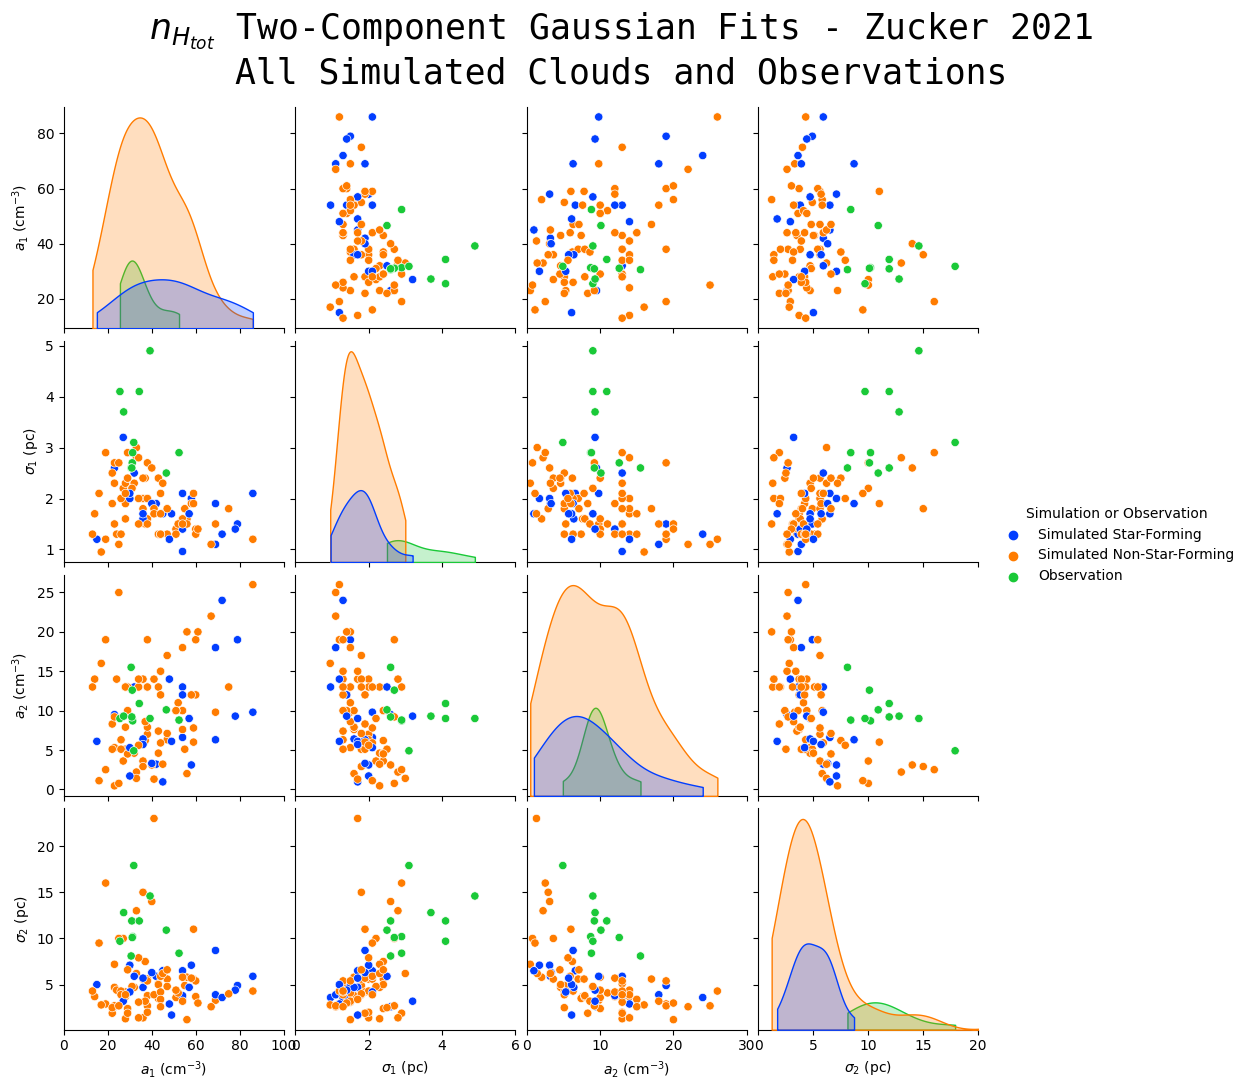

In [53]:
df = pd.concat([dfa1,dfs1,dfa2,dfs2,df_type,],axis = 1)

diag_kws = {'cut' : 0}
g = seaborn.pairplot(df,hue='Simulation or Observation', palette=palette, 
                     diag_kind = 'kde',diag_kws = diag_kws)


g.fig.suptitle("$n_{H_{tot}}$ Two-Component Gaussian Fits - Zucker 2021\nAll Simulated Clouds and Observations", y=1.08,
              fontsize=25, family='monospace')

g.axes[3,0].set_xlim((0,100))
g.axes[3,1].set_xlim((0,6))
g.axes[3,2].set_xlim((0,30))
g.axes[3,3].set_xlim((0,20))

g.axes[0,0].yaxis.set_label_text('$a_1$ (cm$^{-3}$)')
g.axes[1,0].yaxis.set_label_text('$\sigma_1$ (pc)')
g.axes[2,0].yaxis.set_label_text('$a_2$ (cm$^{-3}$)')
g.axes[3,0].yaxis.set_label_text('$\sigma_2$ (pc)')

g.axes[3,0].xaxis.set_label_text('$a_1$ (cm$^{-3}$)')
g.axes[3,1].xaxis.set_label_text('$\sigma_1$ (pc)')
g.axes[3,2].xaxis.set_label_text('$a_2$ (cm$^{-3}$)')
g.axes[3,3].xaxis.set_label_text('$\sigma_2$ (pc)')

g.fig.suptitle("$n_{H_{tot}}$ Two-Component Gaussian Fits - Zucker 2021\nAll Simulated Clouds and Observations", y=1.08,
              fontsize=25, family='monospace')